In [1]:
import geoutils as gu
import numpy as np
import xdem
import os
import shutil
import xarray as xr
import rioxarray as rioxr
import geopandas as gpd
import matplotlib.pyplot as plt
import proplot as pplt
from xdem.spatialstats import nmad
import pandas as pd
from matplotlib.ticker import FuncFormatter
import gc

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pth='D:\\Key_works\\20231212dh_calculate'
pth_gla='D:\\Key_works\\20231212dh_calculate\\gla\\CGI1'
pth_dh='D:\\Key_works\\20231212dh_calculate\\results\\dh_coreg_xc'
pth_srtm='D:\\Key_works\\20231212dh_calculate\\srtm'
pth_srtm_fill='D:\\Key_works\\20231212dh_calculate\\srtm_fill'

### 选择西南河流的图幅

In [4]:
dxt_ix=pth+'/xnhl_test/shp/dxt_group_xn.shp'
df_dxt=gpd.read_file(dxt_ix)

####选取研究区内的dh
group_lst=[]
for i in df_dxt.reg_group.values:
    if i is not None:
        ist=i.split('+')
        for j in ist:
            group_lst.append(j)
group_lst=list(set(group_lst))# 去除重复元素 保证标识的唯一性

In [5]:
len(group_lst)

261

### 对srtm x波段的穿透进行校正
    RSE 2022: Evolution of geodetic mass balance over the largest lake-terminating glacier 
    in the Tibetan Plateau with a revised radar penetration depth based on
    multi-source high-resolution satellite data

    X-band penetration
    Snow/firn 3.19±0.89   Bare ice 0.96±1.10  Debris-covered 0.00
    region_wide_average 1.84±0.59

    Pene_Cband=Pene_X + Pene_C-X

### pene_depth = ELe*0.0068-34.3368
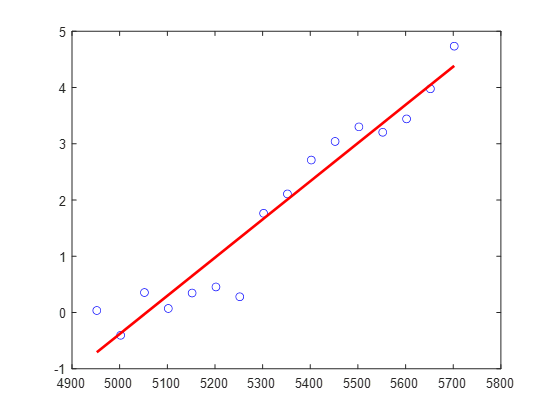

In [7]:
pth_dh_xnhl=pth+'/xnhl_test/dh_pene_all'

In [8]:
for i in group_lst:
    nmi=pth_dh+'\\'+i+'_dh_coreg_penexc.tif'
    if not (os.path.exists(nmi)): continue
    dh = xdem.DEM(nmi)
    
    demnm=pth_srtm+'\\'+i+'_srtm.tif'
    ref_dem0 = xdem.DEM(demnm)
    ref_dem=ref_dem0.reproject(dh)

    glai=pth_gla+'\\'+i+'_gla.shp'
    glacier_outlines = gu.Vector(glai)
    mask_glacier = glacier_outlines.create_mask(ref_dem)
    #ref_dem2=ref_dem.to_xarray()
    dem_mk = ref_dem*mask_glacier
    dem_arr=dem_mk.to_xarray()
    dem_arr1=dem_arr.where((dem_arr!=0)&(dem_arr!=dem_arr._FillValue))
    dem_arr1.values[dem_arr1.values<4950]=4950
    dem_arr1.values[dem_arr1.values>5800]=5800
    x_pene_depth = dem_arr1*0.0068-34.3368
    
    dsi_xpene=dh+x_pene_depth.fillna(0).values
    outnmx=pth_dh_xnhl+'/'+i+'_dh_coreg_pene.tif'
    dsi_xpene.save(outnmx)
    #break    

### 根据xdem计算不确定性
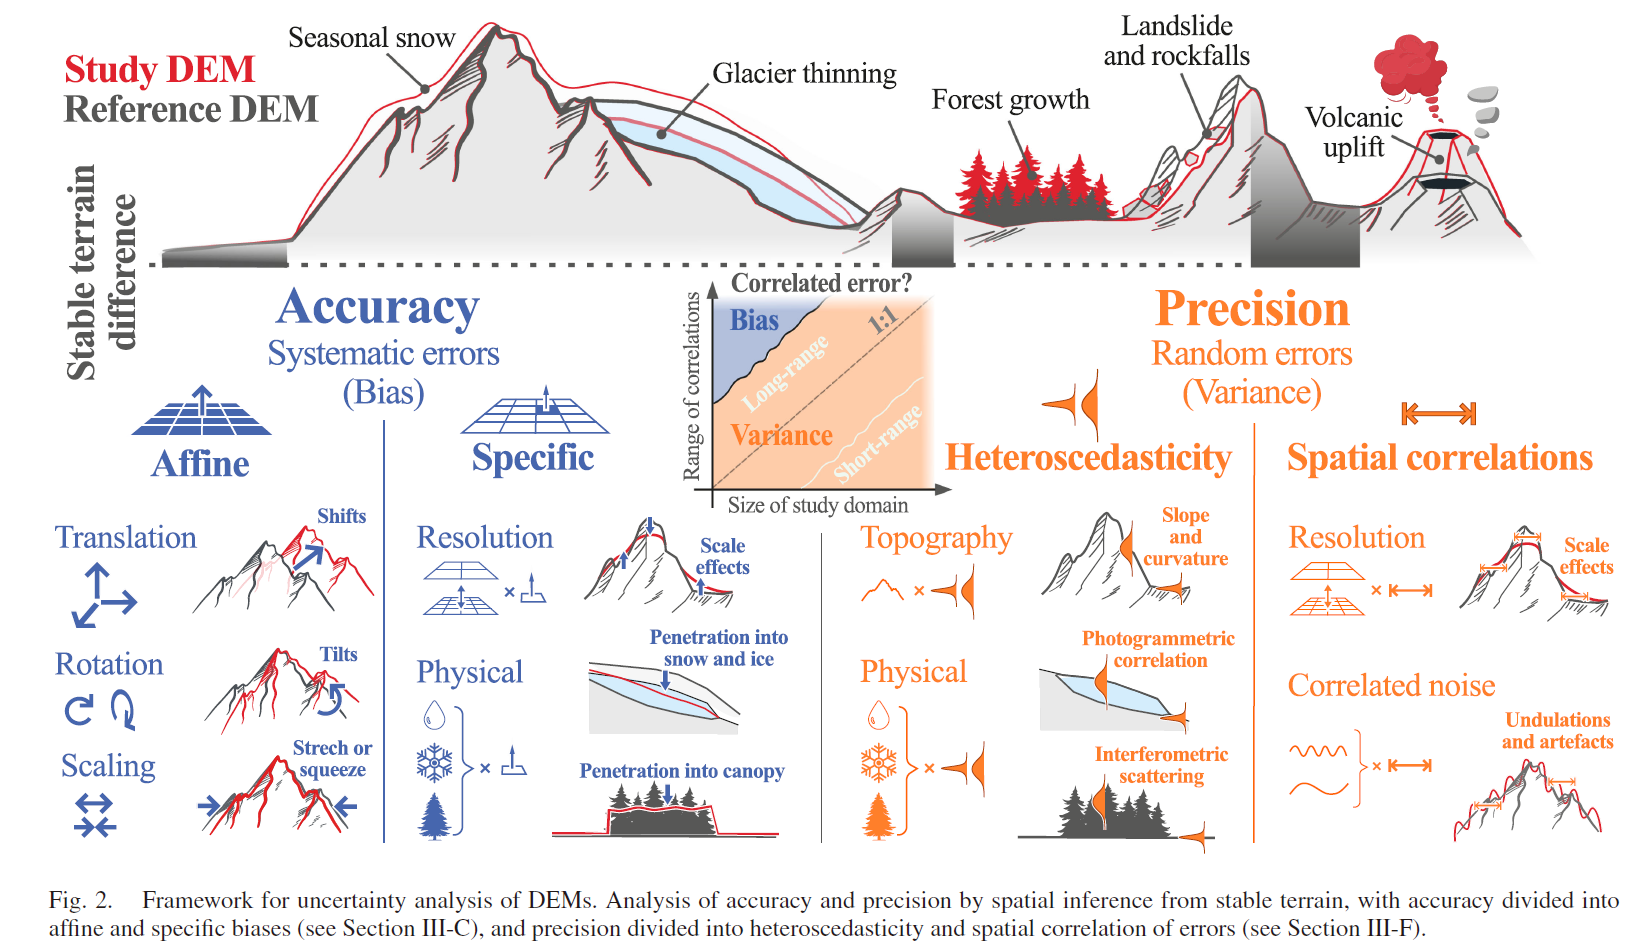

In [9]:
from typing import Any, Callable, Iterable, Literal, TypedDict, overload
from xdem._typing import NDArrayf
import matplotlib
def plot_variogram(
    df: pd.DataFrame,
    list_fit_fun: list[Callable[[NDArrayf], NDArrayf]] = None,
    list_fit_fun_label: list[str] = None,
    ax: matplotlib.axes.Axes = None,
    xscale: str = "linear",
    xscale_range_split: list[float] = None,
    xlabel: str = None,
    ylabel: str = None,
    xlim: str = None,
    ylim: str = None,
    out_fname: str = None,
) -> None:
    """
    Plot empirical variogram, and optionally also plot one or several model fits.
    Input dataframe is expected to be the output of xdem.spatialstats.sample_empirical_variogram.
    Input function model is expected to be the output of xdem.spatialstats.fit_sum_model_variogram.

    :param df: Empirical variogram, formatted as a dataframe with count (pairwise sample count), lags
        (upper bound of spatial lag bin), exp (experimental variance), and err_exp (error on experimental variance)
    :param list_fit_fun: List of model function fits
    :param list_fit_fun_label: List of model function fits labels
    :param ax: Plotting ax to use, creates a new one by default
    :param xscale: Scale of X-axis
    :param xscale_range_split: List of ranges at which to split the figure
    :param xlabel: Label of X-axis
    :param ylabel: Label of Y-axis
    :param xlim: Limits of X-axis
    :param ylim: Limits of Y-axis
    :param out_fname: File to save the variogram plot to
    :return:
    """

    # Create axes if they are not passed
    if ax is None:
        fig = plt.figure()
        ax = plt.subplot(111)
    elif isinstance(ax, matplotlib.axes.Axes):
        fig = ax.figure
    else:
        raise ValueError("ax must be a matplotlib.axes.Axes instance or None")

    # Check format of input dataframe
    expected_values = ["exp", "lags", "count"]
    for val in expected_values:
        if val not in df.columns.values:
            raise ValueError(f'The expected variable "{val}" is not part of the provided dataframe column names.')

    # Hide axes for the main subplot (which will be subdivded)
    ax.axis("off")

    if ylabel is None:
        ylabel = r"Variance [$\mu$ $\pm \sigma$]"
    if xlabel is None:
        xlabel = "Spatial lag (m)"

    init_gridsize = [10, 10]
    # Create parameters to split x axis into different linear scales
    # If there is no split, get parameters for a single subplot
    if xscale_range_split is None:
        nb_subpanels = 1
        if xscale == "log":
            xmin = [np.min(df.lags) / 2]
        else:
            xmin = [0]
        xmax = [np.max(df.lags)]
        xgridmin = [0]
        xgridmax = [init_gridsize[0]]
        gridsize = init_gridsize
    # Otherwise, derive a list for each subplot
    else:
        # Add initial zero if not in input
        if xscale_range_split[0] != 0:
            if xscale == "log":
                first_xmin = np.min(df.lags) / 2
            else:
                first_xmin = 0
            xscale_range_split = [first_xmin] + xscale_range_split
        # Add maximum distance if not in input
        if xscale_range_split[-1] != np.max(df.lags):
            xscale_range_split.append(np.max(df.lags))

        # Scale grid size by the number of subpanels
        nb_subpanels = len(xscale_range_split) - 1
        gridsize = init_gridsize.copy()
        gridsize[0] *= nb_subpanels
        # Create list of parameters to pass to ax/grid objects of subpanels
        xmin = []
        xmax = []
        xgridmin = []
        xgridmax = []
        for i in range(nb_subpanels):
            xmin.append(xscale_range_split[i])
            xmax.append(xscale_range_split[i + 1])
            xgridmin.append(init_gridsize[0] * i)
            xgridmax.append(init_gridsize[0] * (i + 1))

    # Need a grid plot to show the sample count and the statistic
    grid = plt.GridSpec(gridsize[1], gridsize[0], wspace=0.5, hspace=0.5)

    # Loop over each subpanel
    for k in range(nb_subpanels):
        # First, an axis to plot the sample histogram
        ax0 = ax.inset_axes(grid[:3, xgridmin[k] : xgridmax[k]].get_position(fig).bounds)
        ax0.set_xscale(xscale)
        ax0.set_xticks([])
        #ax0.grid(ls='--')

        # Plot the histogram manually with fill_between
        interval_var = [0] + list(df.lags)
        for i in range(len(df)):
            count = df["count"].values[i]
            ax0.fill_between(
                [interval_var[i], interval_var[i + 1]],
                [0] * 2,
                [count] * 2,
                facecolor=plt.cm.Greys(0.75),
                alpha=1,
                edgecolor="white",
                linewidth=0.5,
            )
        if k == 0:
            ax0.set_ylabel("Sample count")
            # Scientific format to avoid undesired additional space on the label side
            ax0.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
        else:
            ax0.set_yticks([])
        # Ignore warnings for log scales
        ax0.set_xlim((xmin[k], xmax[k]))

        # Now, plot the statistic of the data
        ax1 = ax.inset_axes(grid[3:, xgridmin[k] : xgridmax[k]].get_position(fig).bounds)
        ax1.grid(ls='--')

        # Get the lags bin centers
        bins_center = np.subtract(df.lags, np.diff([0] + df.lags.tolist()) / 2)

        # If all the estimated errors are all NaN (single run), simply plot the empirical variogram
        if np.all(np.isnan(df.err_exp)):
            ax1.scatter(bins_center, df.exp, label="Empirical variogram", color="blue", marker="x")
        # Otherwise, plot the error estimates through multiple runs
        else:
            ax1.errorbar(bins_center, df.exp, yerr=df.err_exp, label="Empirical variogram (1-sigma std error)", fmt="x")

        # If a list of functions is passed, plot the modelled variograms
        if list_fit_fun is not None:
            for i, fit_fun in enumerate(list_fit_fun):
                x = np.linspace(xmin[k], xmax[k], 1000)
                y = fit_fun(x)

                if list_fit_fun_label is not None:
                    ax1.plot(x, y, linestyle="dashed", label=list_fit_fun_label[i], zorder=30)
                else:
                    ax1.plot(x, y, linestyle="dashed", color="black", zorder=30)

            if list_fit_fun_label is None:
                ax1.plot([], [], linestyle="dashed", color="black", label="Model fit")

        ax1.set_xscale(xscale)
        if nb_subpanels > 1 and k == (nb_subpanels - 1):
            ax1.xaxis.set_ticks(np.linspace(xmin[k], xmax[k], 3))
        elif nb_subpanels > 1:
            ax1.xaxis.set_ticks(np.linspace(xmin[k], xmax[k], 3)[:-1])

        if xlim is None:
            ax1.set_xlim((xmin[k], xmax[k]))
        else:
            ax1.set_xlim(xlim)

        if ylim is not None:
            ax1.set_ylim(ylim)
        else:
            if np.all(np.isnan(df.err_exp)):
                ax1.set_ylim((0, 1.05 * np.nanmax(df.exp)))
            else:
                ax1.set_ylim((0, np.nanmax(df.exp) + np.nanmean(df.err_exp)))

        if k == int(nb_subpanels / 2):
            ax1.set_xlabel(xlabel)
        if k == nb_subpanels - 1:
            ax1.legend(loc="lower right")
        if k == 0:
            ax1.set_ylabel(ylabel)
        else:
            ax1.set_yticks([])
    #ax.grid(ls='--')
    #if out_fname is not None:
    plt.savefig(out_fname,bbox_inches ='tight',dpi=600)

In [10]:
group_lst.sort()

In [11]:
pth_dh_xnhl=pth+'/xnhl_test/dh_pene_all'

In [12]:
####用于绘制频率分布图
def to_percent(y,position):
    return str(round(100*y,2))+"%"
def paint(ds_val,ds_val1,offg_fig):
    fig,ax=plt.subplots(1,1,figsize=(3,4))
    ax_hist2=ax.hist(ds_val1.reshape(-1), bins=100,  weights = np.zeros_like(ds_val1.reshape(-1)) + 1 / len(ds_val1.reshape(-1)),
                     facecolor="red", edgecolor="black", alpha=0.4,label='Before correction',zorder=2)
    ax_hist1=ax.hist(ds_val.reshape(-1), bins=100,  weights = np.zeros_like(ds_val.reshape(-1)) + 1 / len(ds_val.reshape(-1)),
                     facecolor="blue", edgecolor="black", alpha=0.7,label='After correction',zorder=1)
    
    fomatter=FuncFormatter(to_percent)
    ax.yaxis.set_major_formatter(fomatter)
    ax.legend(loc=1,ncol=2,bbox_to_anchor=(1.05,1.07),frameon=False)
    ax.set_xlabel('Elevation diff. in off-glacier (m)')
    plt.savefig(offg_fig,dpi=300,bbox_inches='tight')
    plt.close()

In [13]:
def binning2D(slope_arr,maxc_arr):
    # Define bins for 2D binning
    custom_bin_slope = np.unique(
        np.concatenate(
            [
                np.nanquantile(slope_arr, np.linspace(0, 0.95, 20)),
                np.nanquantile(slope_arr, np.linspace(0.96, 0.99, 5)),
                np.nanquantile(slope_arr, np.linspace(0.991, 1, 10)),
            ]
        )
    )
    
    custom_bin_curvature = np.unique(
        np.concatenate(
            [
                np.nanquantile(maxc_arr, np.linspace(0, 0.95, 20)),
                np.nanquantile(maxc_arr, np.linspace(0.96, 0.99, 5)),
                np.nanquantile(maxc_arr, np.linspace(0.991, 1, 10)),
            ]
        )
    )
    return custom_bin_slope,custom_bin_curvature

In [31]:
#fche=open(pth+'/xnhl_test/Notcla_glacier.csv','w')
#fche.write('group,glacier_code\n')

plt.rcParams['font.size'] = 10
plt.rcParams['font.sans-serif']='times new roman'
plt.rcParams['grid.linestyle'] = '--'
plt.switch_backend('Agg')
for i in group_lst:  
    nmi=pth_dh_xnhl+'/'+i+'_dh_coreg_pene.tif'
    nmj=pth+'/results/dh/'+i+'_dh.tif'
    if (not (os.path.exists(nmi))): continue
    print(i,' processing!')
    #if os.path.exists(pth+'/xnhl_test/spatial_corr_analysis/vgm_params/'+i+'_corr.csv'):
    #    print(i,' done!')
    #    continue
    
    dh = xdem.DEM(nmi)
    if dh.res[0]!=dh.res[1]:
        dh=dh.reproject(dst_res=30)  ##分辨率不一致，计算坡度这些会报错
    dh_orig = xdem.DEM(nmj)
    if dh_orig.res[0]!=dh_orig.res[1]:
        dh_orig=dh_orig.reproject(dst_res=30)  ##分辨率不一致，计算坡度这些会报错
    
    demnm=pth_srtm+'\\'+i+'_srtm.tif'
    ref_dem0 = xdem.DEM(demnm)
    ref_dem=ref_dem0.reproject(dh)
    #########
    demnm_fill=pth_srtm_fill+'\\'+i+'_srtm.tif'
    ref_dem0 = xdem.DEM(demnm_fill)
    ref_dem_fill=ref_dem0.reproject(dh)
    ########
    
    glai=pth_gla+'\\'+i+'_gla.shp'
    glacier_outlines = gu.Vector(glai)
    mask_glacier = glacier_outlines.create_mask(dh)
    mask_glacier_orig = glacier_outlines.create_mask(dh_orig)
    
    vgm_nm=pth+'/xnhl_test/spatial_corr_analysis/vgm_params/'+i+'_corr.csv'
    if os.path.exists(vgm_nm):
        params_vgm=pd.read_csv(vgm_nm)
        herero_nm=pth+'/xnhl_test/group_err/'+i+'_heteroscedasticity.tif'
        #dh_xx.rio.to_raster(herero_nm)
        #dh_err=xr.open_dataset(herero_nm,engine='rasterio')
        dh_err=xdem.DEM(herero_nm).data
        #print(dh_err)
        z_dh = dh.data / dh_err
        # remove values on glacierized terrain and large outliers
        z_dh.data[mask_glacier.data] = np.nan
        z_dh.data[np.abs(z_dh.data) > 3] = np.nan
        scale_fac_std = nmad(z_dh.data)
    else:      
        
        # Compute the slope and maximum curvature
        slope, planc, profc = xdem.terrain.get_terrain_attribute(
        dem=ref_dem, attribute=["slope", "planform_curvature", "profile_curvature"])
        # Remove values on unstable terrain
        dh_arr = dh[~mask_glacier].filled(np.nan)
        dh_arr_orig = dh_orig[~mask_glacier_orig].filled(np.nan)
        slope_arr = slope[~mask_glacier].filled(np.nan)
        planc_arr = planc[~mask_glacier].filled(np.nan)
        profc_arr = profc[~mask_glacier].filled(np.nan)
        maxc_arr = np.maximum(np.abs(planc_arr), np.abs(profc_arr))
        # Remove large outliers
        nmad_ngla=xdem.spatialstats.nmad(dh_arr)
        nmad_ngla_orig=xdem.spatialstats.nmad(dh_arr_orig)
        dh_arr[np.abs(dh_arr) > 3 * nmad_ngla] = np.nan
        dh_arr_orig[np.abs(dh_arr_orig) > 3 * nmad_ngla_orig] = np.nan
        
    
        group_error=open(pth+'/xnhl_test/group_err/%s_heteroscedasticitys.csv'%i,'w')
        group_error.write('median,nmad,median_bf,nmad_bf\n')
        group_error.write('%.4f,%.4f,%.4f,%.4f\n'%(np.nanmedian(dh_arr),nmad_ngla,np.nanmedian(dh_arr_orig),nmad_ngla_orig))
        group_error.close()
        offg_fig=pth+'/xnhl_test/group_err/'+i+'_nangla_hist.svg'
        paint(dh_arr[~np.isnan(dh_arr)],dh_arr_orig[~np.isnan(dh_arr_orig)],offg_fig)
        del planc_arr ,profc_arr,dh_arr_orig,dh_orig
        ######################################################################################################
        # dh_arr  slope_arr  maxc_arr  glacier_outlines
        #######################
        # Define bins for 2D binning
        custom_bin_slope,custom_bin_curvature=binning2D(slope_arr,maxc_arr)
        # Perform 2D binning to estimate the measurement error with slope and maximum curvature
        df = xdem.spatialstats.nd_binning(
            values=dh_arr,
            list_var=[slope_arr, maxc_arr],
            list_var_names=["slope", "maxc"],
            statistics=["count", np.nanmedian, nmad],
            list_var_bins=[custom_bin_slope, custom_bin_curvature],
        )
        # Estimate an interpolant of the measurement error with slope and maximum curvature
        slope_curv_to_dh_err = xdem.spatialstats.interp_nd_binning(
            df, list_var_names=["slope", "maxc"], statistic="nmad", min_count=30)
        maxc = np.maximum(np.abs(profc), np.abs(planc))
        # Estimate a measurement error per pixel
        dh_err = slope_curv_to_dh_err((slope.data, maxc.data))
        dh_xx=dh.to_xarray()
        dh_xx.values=[dh_err]
        herero_nm=pth+'/xnhl_test/group_err/'+i+'_heteroscedasticity.tif'
        dh_xx.rio.to_raster(herero_nm)
        del dh_xx
        ##################################################################################################
        #standardize the elevation differences by applying a simple division
        z_dh = dh.data / dh_err
        # remove values on glacierized terrain and large outliers
        z_dh.data[mask_glacier.data] = np.nan
        z_dh.data[np.abs(z_dh.data) > 3] = np.nan
    
        print(f"NMAD before scale-correction: {nmad(z_dh.data):.1f}")
        scale_fac_std = nmad(z_dh.data)
        z_dh = z_dh / scale_fac_std
        print(f"NMAD after scale-correction: {nmad(z_dh.data):.1f}")
        #################################################
        ##perform an analysis of spatial correlation as shown in the Estimation and modelling of spatial variograms example, 
        #by estimating a variogram and fitting a sum of two models. 
        #Dowd’s variogram is used for robustness in conjunction with the NMAD
        df_vgm = xdem.spatialstats.sample_empirical_variogram(
            values=z_dh.data.squeeze(),
            gsd=dh.res[0],
            subsample=5000,
            n_variograms=10,
            estimator="dowd",
            random_state=42,)
        try:
            func_sum_vgm, params_vgm = xdem.spatialstats.fit_sum_model_variogram(["Gaussian", "Spherical"], empirical_variogram=df_vgm) #Spherical Gaussian
        except:
            func_sum_vgm, params_vgm = xdem.spatialstats.fit_sum_model_variogram(["Gaussian", "Gaussian"], empirical_variogram=df_vgm) #Spherical Gaussian
        
        params_vgm.to_csv(vgm_nm)
    
        #####绘制变差图，用于检测空间自相关信息
        fig,ax=plt.subplots(1,1,figsize=(6.5,5))
        fignm0=pth+'/xnhl_test/spatial_corr_analysis/variogram_fig/'+i+'_range.tif'
        fignm1=pth+'/xnhl_test/spatial_corr_analysis/variogram_fig/'+i+'_log.tif'
        plot_variogram(df_vgm,xscale_range_split=[100, 1000, 10000],list_fit_fun=[func_sum_vgm],
            list_fit_fun_label=["Standardized double-range variogram"],ax=ax,out_fname=fignm0)
        plt.close()
        fig,ax=plt.subplots(1,1,figsize=(6.5,5))
        plot_variogram(df_vgm,xscale='log',list_fit_fun=[func_sum_vgm],
            list_fit_fun_label=["Standardized double-range variogram"],ax=ax,out_fname=fignm1)
        plt.close()
        #ax.grid('--')
    ################################################################################
    #计算每条冰川的dh 不确定性
    ################################################################################
    stat_nm=pth+'/xnhl_test/error_glacier/error_%s.csv'%i
    fstat=open(stat_nm,'w')
    fstat.write('gla_id,effective samples,dh_error\n')
    
    for gg_code in glacier_outlines.ds['Glc_Code']:
        gg_shp = gu.Vector(glacier_outlines.ds[glacier_outlines.ds["Glc_Code"] == gg_code])
        gg_mask = gg_shp.create_mask(dh)
        ##计算有效像元数量
        gg_neff = xdem.spatialstats.neff_circular_approx_numerical(area=gg_shp.ds.area.values[0], params_variogram_model=params_vgm)
        ##integrated error
        gg_z_err = 1 / np.sqrt(gg_neff)
        # Destandardize the uncertainty
        try:
            fac_gg_dh_err = scale_fac_std * np.nanmean(dh_err[gg_mask.data])
            #dh_mean=np.nanmean(dh[gg_mask.data])
        except:
            fac_gg_dh_err=np.nan
        gg_dh_err = fac_gg_dh_err * gg_z_err
        fstat.write('%s,%s,%s\n'%(gg_code,gg_neff,gg_dh_err))
    fstat.close()
    gc.collect()
    print(i,' done!')
    #break

g0001  processing!
g0001  done!
g0002  processing!
g0002  done!
g0004  processing!
g0004  done!
g0005  processing!
g0005  done!
g0006  processing!
g0006  done!
g0007  processing!
g0007  done!
g0008  processing!
g0008  done!
g0011  processing!
g0011  done!
g0015  processing!
g0015  done!
g0016  processing!
g0016  done!
g0017  processing!
g0017  done!
g0018  processing!
g0018  done!
g0020  processing!
g0020  done!
g0021  processing!
g0021  done!
g0022  processing!
g0022  done!
g0023  processing!
g0023  done!
g0024  processing!
g0024  done!
g0025  processing!
g0025  done!
g0026  processing!
g0026  done!
g0027  processing!
g0027  done!
g0028  processing!
g0028  done!
g0029  processing!
g0029  done!
g0030  processing!
g0030  done!
g0031  processing!
g0031  done!
g0032  processing!
g0032  done!
g0033  processing!
g0033  done!
g0034  processing!
g0034  done!
g0035  processing!
g0035  done!
g0038  processing!
g0038  done!
g0039  processing!
g0039  done!
g0040  processing!
g0040  done!
g0041  p

In [187]:
%matplotlib inline

<AxesSubplot:>

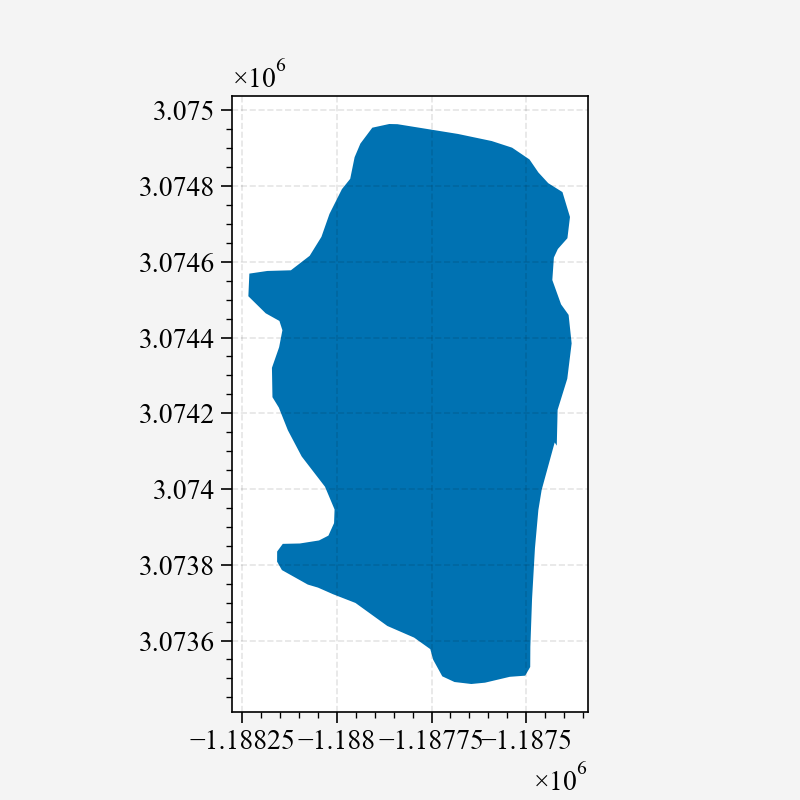

In [133]:
glai=pth_gla+'\\g0218'+'_gla.shp'
glacier_outlines = gu.Vector(glai)
glacier_outlines.ds[glacier_outlines.ds["Glc_Code"] == 'G092730E28475N'].plot()

<AxesSubplot:title={'center':'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

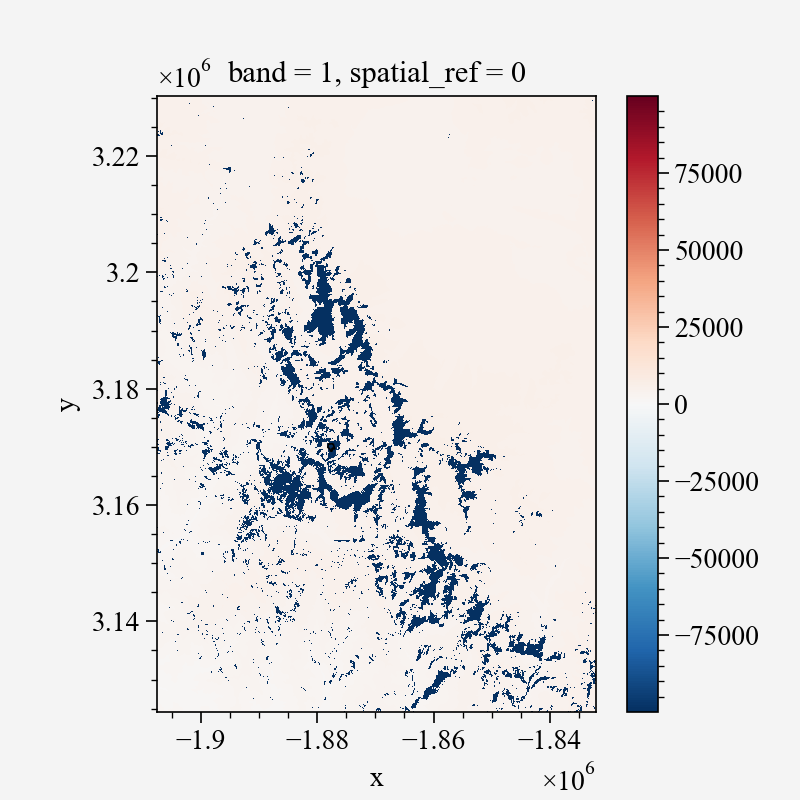

In [30]:
fig,ax=plt.subplots(1,1)
ref_dem.to_xarray().plot(ax=ax)
gg_shp.ds.plot(ax=ax,facecolor='none')

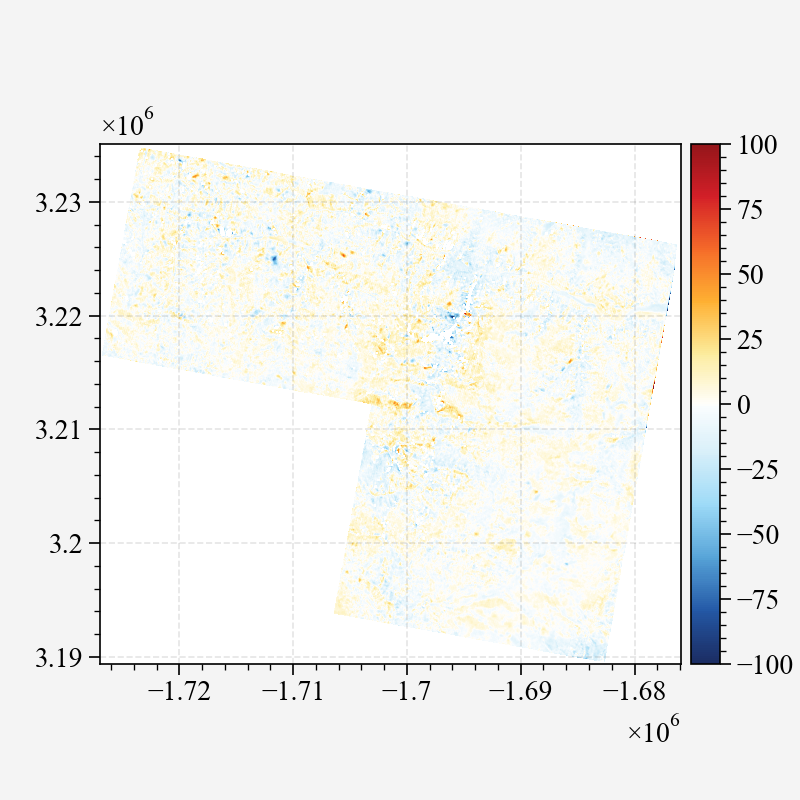

In [16]:
dh.show(cmap='coldhot',vmax=100,vmin=-100)